# Exploring possible targets for NuSTAR - 2024

## Import Statements

In [1]:
from astropy.units import Quantity
import astropy.units as u
from astropy.cosmology import FlatLambdaCDM
from astropy.coordinates import SkyCoord
from astropy.table import Table
from astropy.io import fits
import pandas as pd
pd.options.display.max_rows = 999
pd.set_option("max_colwidth", 100)
pd.set_option('display.max_columns', 500)
import numpy as np
import os
from tqdm import tqdm
from matplotlib import pyplot as plt
import warnings

from xga.products import Image
from xga.imagetools.misc import physical_rad_to_pix
from xga.sourcetools.misc import rad_to_ang
from xga.imagetools.profile import annular_mask
from xga.products import ExpMap

%matplotlib inline
warnings.filterwarnings('ignore')

## Define the cosmology

In [2]:
cosmo = FlatLambdaCDM(70, 0.3)

## Read in the sample

In [3]:
samp = pd.read_csv("../../sample_files/lovoccs_southnorth.csv")
samp['LoVoCCS_name'] = samp['LoVoCCSID'].apply(lambda x: 'LoVoCCS-' + str(x))

check = pd.read_csv(("../../../LoVoCCS-Sample/paper_specific_subsamples/proposals/NuSTAR/"
                     "lovoccs_checklist_lite.csv"))

check['Name'] = check['Name'].apply(lambda x: x.replace('RXC ', 'RXC').replace("RBS ", "RBS")
                                    .replace("APMCC ", "APMCC").replace("MKW ", "MKW"))

In [4]:
on_other = pd.merge(samp, check, left_on="other_names", right_on="Name", how="right")
on_alt = pd.merge(samp, check, left_on="alt_name", right_on="Name", how="right")
rel_samp = pd.concat([on_other[~on_other['LoVoCCSID'].isna()], 
                      on_alt[~on_alt['LoVoCCSID'].isna()]]).drop_duplicates('LoVoCCSID')
rel_samp['LoVoCCSID'] = rel_samp['LoVoCCSID'].astype(int)
rel_samp = rel_samp.reset_index(drop=True)

In [5]:
check[~check['Name'].isin(rel_samp.Name)]

,ID,Name,RA,DEC,Redshift,Newly processed,Fully observed,Comments


We reduce the sample to only those clusters which have been fully observed by our optical survey:

In [6]:
# rel_samp = rel_samp[rel_samp['Fully observed'] == 'yes'].reset_index(drop=True)
rel_samp['Fully observed'].value_counts()

yes          82
partially    22
no            2
almost        1
Name: Fully observed, dtype: int64

In [7]:
rel_samp['sub_samp'].value_counts()

south    102
north      5
Name: sub_samp, dtype: int64

## NuSTAR coverage of the LoVoCCS sample

In [8]:
field_nustar_cov_frac = []
r500_nustar_cov_frac = []
rvir_nustar_cov_frac = []

for row_ind, row in samp.iterrows():
    cov_path = "../../outputs/coverage_maps/fits/{n}_550pix_20.0arcsec.fits".format(n=row["LoVoCCS_name"])
    cur_cheese = ExpMap(cov_path, '', '', '', '', '', Quantity(0.5, 'keV'), Quantity(2.0, 'keV'))
    with fits.open(cov_path) as covero:
        if row_ind == 0:
            print(covero[0].header['MISSION*'])
            
        cov_arr = covero[0].data
        nustar_cov_arr = cov_arr[4, :, :]
        
        field_nustar_cov_frac.append(nustar_cov_arr.sum() / (nustar_cov_arr.shape[0]*nustar_cov_arr.shape[1]))
        
        pix_cen = Quantity([nustar_cov_arr.shape[0]/2, nustar_cov_arr.shape[1]/2], 'pix').round(0).astype(int)
        rad = Quantity(row['R500'], 'Mpc')
        
        pix_rad = physical_rad_to_pix(cur_cheese, rad, pix_cen, row['redshift'], cosmo)
        
        rad_mask = annular_mask(pix_cen, np.array([0]), np.array([pix_rad.value]), nustar_cov_arr.shape)
        msk_nustar_cov = nustar_cov_arr*rad_mask
        r500_nustar_cov_frac.append(msk_nustar_cov.sum() / rad_mask.sum())
        
        samp.loc[row_ind, 'NUSTAR_R500_FRAC'] = r500_nustar_cov_frac[row_ind]

MISSION1= 'xmm_pointed'                                                         MISSION2= 'chandra '                                                            MISSION3= 'rosat_pointed_pspc'                                                  MISSION4= 'rosat_pointed_hri'                                                   MISSION5= 'nustar_pointed'                                                      MISSION6= 'swift_xrt'                                                           MISSION7= 'asca    '                                                            END                                                                                                                                                                                                                                                                                                                                                                                                                                                     

In [9]:
field_nustar_cov_frac = []
r500_nustar_cov_frac = []
rvir_nustar_cov_frac = []

for row_ind, row in rel_samp.iterrows():
    cov_path = "../../outputs/coverage_maps/fits/{n}_550pix_20.0arcsec.fits".format(n=row["LoVoCCS_name"])
    cur_cheese = ExpMap(cov_path, '', '', '', '', '', Quantity(0.5, 'keV'), Quantity(2.0, 'keV'))
    with fits.open(cov_path) as covero:
        if row_ind == 0:
            print(covero[0].header['MISSION*'])
            
        cov_arr = covero[0].data
        nustar_cov_arr = cov_arr[4, :, :]
        
        field_nustar_cov_frac.append(nustar_cov_arr.sum() / (nustar_cov_arr.shape[0]*nustar_cov_arr.shape[1]))
        
        pix_cen = Quantity([nustar_cov_arr.shape[0]/2, nustar_cov_arr.shape[1]/2], 'pix').round(0).astype(int)
        rad = Quantity(row['R500'], 'Mpc')
        
        pix_rad = physical_rad_to_pix(cur_cheese, rad, pix_cen, row['redshift'], cosmo)
        
        rad_mask = annular_mask(pix_cen, np.array([0]), np.array([pix_rad.value]), nustar_cov_arr.shape)
        msk_nustar_cov = nustar_cov_arr*rad_mask
        r500_nustar_cov_frac.append(msk_nustar_cov.sum() / rad_mask.sum())
        
        rel_samp.loc[row_ind, 'NUSTAR_R500_FRAC'] = r500_nustar_cov_frac[row_ind]

MISSION1= 'xmm_pointed'                                                         MISSION2= 'chandra '                                                            MISSION3= 'rosat_pointed_pspc'                                                  MISSION4= 'rosat_pointed_hri'                                                   MISSION5= 'nustar_pointed'                                                      MISSION6= 'swift_xrt'                                                           MISSION7= 'asca    '                                                            END                                                                                                                                                                                                                                                                                                                                                                                                                                                     

### Distribution of coverage of 3.06$^{\circ}$x3.06$^{\circ}$ field centered on MCXC position

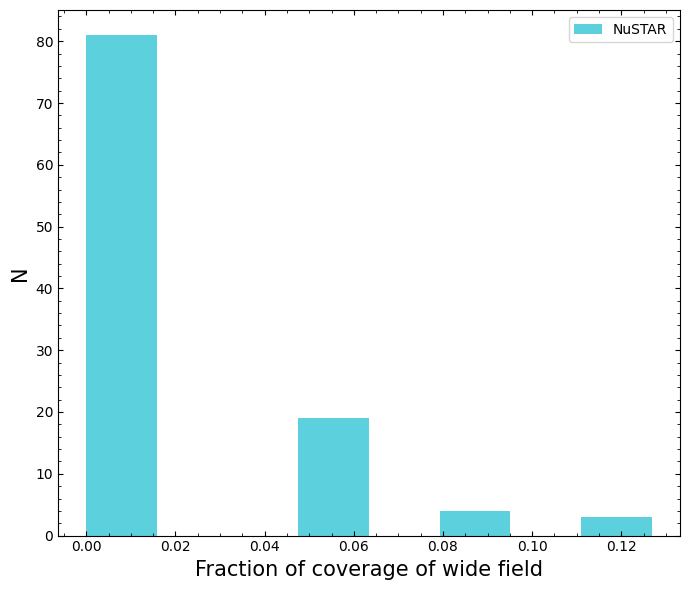

In [13]:
plt.figure(figsize=(7, 6))
plt.minorticks_on()
plt.tick_params(which='both', direction='in', top=True, right=True)
plt.hist(field_nustar_cov_frac, bins='auto', color='tab:cyan', alpha=0.7, label='NuSTAR')
plt.ylabel('N', fontsize=15)
plt.xlabel(r'Fraction of coverage of wide field', fontsize=15)

plt.legend(loc='best')
plt.tight_layout()
plt.show()

### Distribution of coverage of MCXC $R_{500}$ centered on MCXC position

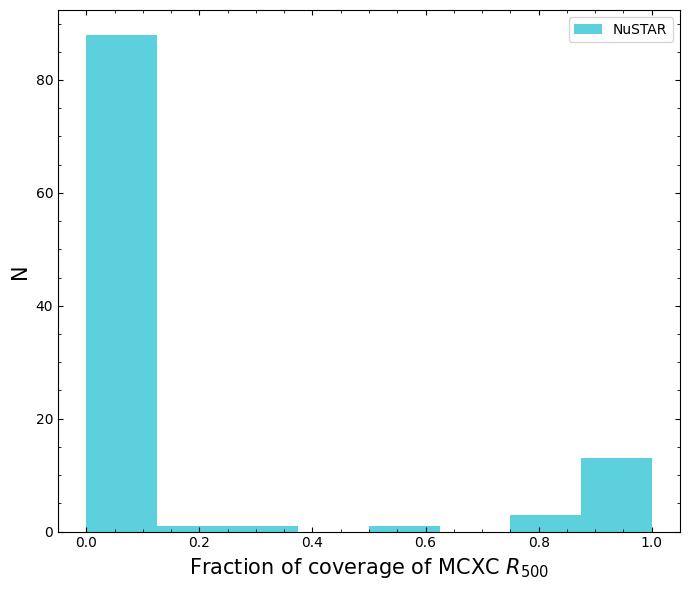

In [14]:
plt.figure(figsize=(7, 6))
plt.minorticks_on()
plt.tick_params(which='both', direction='in', top=True, right=True)
plt.hist(r500_nustar_cov_frac, bins='auto', color='tab:cyan', alpha=0.7, label='NuSTAR')

plt.ylabel('N', fontsize=15)
plt.xlabel(r'Fraction of coverage of MCXC $R_{500}$', fontsize=15)

plt.legend(loc='best')
plt.tight_layout()
plt.show()

## No NuSTAR Coverage

The clusters with no NuSTAR observations are all potential targets for this proposal, though we will prioritise based on different criteria. First of all though, there are several clusters which have been found to have planned NuSTAR observations, we will mark them as fully covered in the dataframe (though of course that may not be the case):

### Planned NuSTAR Observations

In [22]:
planned = [0, 2, 4, 5]

sel = rel_samp['LoVoCCSID'].isin(planned)
rel_samp.loc[sel, 'NUSTAR_R500_FRAC'] = 1

sel = samp['LoVoCCSID'].isin(planned)
samp.loc[sel, 'NUSTAR_R500_FRAC'] = 1

In [25]:
poss_targ = rel_samp[rel_samp['NUSTAR_R500_FRAC'] < 0.5]
poss_targ.to_csv("poss_nustar_targets.csv", index=False)
poss_targ

,name,MCXC,LoVoCCSID,LoVoCCS_name,ra,dec,redshift,L500,M500,R500,alt_name,other_names,Notes,sub_samp,old_LoVoCCSID,ID,Name,RA,DEC,Redshift,Newly processed,Fully observed,Comments,NUSTAR_R500_FRAC
4,MCXCJ2201.9-5956,J2201.9-5956,7,LoVoCCS-7,330.483333,-59.949444,0.0980,4.204419,4.5890,1.1367,RXCJ2201.9-5956,A3827,NaN,south,6.0,5,A3827,330.48,-59.95,0.0980,1.0,yes,"Currently using A3825 catalogs. Note the 2 clusters are at very different redshifts, but RS colo...",0.000000
10,MCXCJ0257.8+1302,J0257.8+1302,14,LoVoCCS-14,44.457500,13.049167,0.0722,3.592916,4.2452,1.1169,RXCJ0257.8+1302,A399,NaN,south,13.0,11,A399,44.46,13.05,0.0722,1.0,yes,NaN,0.000000
11,MCXCJ2325.3-1207,J2325.3-1207,15,LoVoCCS-15,351.333333,-12.127222,0.0852,3.557935,4.1821,1.1066,RXCJ2325.3-1207,A2597,NaN,south,14.0,12,A2597,351.33,-12.13,0.0852,1.0,yes,NaN,0.000000
13,MCXCJ0052.7-8015,J0052.7-8015,19,LoVoCCS-19,13.187083,-80.266389,0.1141,3.393306,3.9812,1.0783,RXCJ0052.7-8015,A2837,NaN,south,18.0,14,A2837,13.19,-80.27,0.1141,1.0,yes,NaN,0.000000
15,MCXCJ2034.7-3548,J2034.7-3548,22,LoVoCCS-22,308.699583,-35.813333,0.0894,2.963013,3.7297,1.0637,RXCJ2034.7-3548,A3695,"L,losStr",south,21.0,17,A3695,308.70,-35.81,0.0894,1.0,yes,NaN,0.000000
16,MCXCJ2249.9-6425,J2249.9-6425,24,LoVoCCS-24,342.487500,-64.429444,0.0940,2.828545,3.6139,1.0510,RXCJ2249.9-6425,A3921,losStr,south,23.0,18,A3921,342.49,-64.43,0.0940,1.0,yes,"Offset between peaks of mass map, BCG/Xray. Merging cluster.",0.000000
17,MCXCJ2214.5-1022,J2214.5-1022,26,LoVoCCS-26,333.635833,-10.371667,0.0980,2.770068,3.5581,1.0442,RXCJ2214.5-1022,A2426,NaN,south,25.0,19,A2426,333.64,-10.37,0.0980,NaN,yes,NaN,0.000000
19,MCXCJ0042.1-2832,J0042.1-2832,29,LoVoCCS-29,10.536250,-28.535833,0.1082,2.734146,3.5046,1.0355,RXCJ0042.1-2832,A2811,losStr,south,28.0,22,A2811,10.54,-28.54,0.1082,1.0,yes,NaN,0.000000
20,MCXCJ0918.1-1205,J0918.1-1205,30,LoVoCCS-30,139.527083,-12.093333,0.0539,2.716018,3.6243,1.0658,RXCJ0918.1-1205,A780,BX,south,29.0,23,A780,139.53,-12.09,0.0539,1.0,yes,The BCG is Hydra A (also 3C 218). The mass map extend to East (check montage) and seems also in ...,0.000000
21,MCXCJ2210.3-1210,J2210.3-1210,31,LoVoCCS-31,332.582083,-12.176111,0.0846,2.672473,3.5139,1.0445,RXCJ2210.3-1210,A2420,NaN,south,30.0,24,A2420,332.58,-12.18,0.0846,1.0,yes,NaN,0.000000
